# Imports:

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, preprocessing, losses
import matplotlib.pyplot as plt
from os import listdir, mkdir, path
import numpy as np
from PIL import Image
import pytesseract

# Load Coin Dataset:

In [2]:
labels = listdir('images2/')
labels.sort()

if '.DS_Store' in labels:
  labels.remove('.DS_Store')

dataset = preprocessing.image_dataset_from_directory(
  'images2/',
  labels="inferred",
  label_mode="int",
  class_names=None,
  color_mode="rgb",
  batch_size=32,
  image_size=(500, 500),
  validation_split=0.1,
  subset="training",
  seed=1234,
  shuffle=True
)
dataset_val = preprocessing.image_dataset_from_directory(
  'images2/',
  labels="inferred",
  label_mode="int",
  class_names=None,
  color_mode="rgb",
  batch_size=32,
  image_size=(500, 500),
  validation_split=0.1,
  subset="validation",
  seed=1234,
  shuffle=True
)
dataset = dataset.map(lambda image, label: (image / 255.0, label))
dataset_val = dataset_val.map(lambda image, label: (image / 255.0, label))

Found 5158 files belonging to 10 classes.
Using 4643 files for training.


2021-10-19 20:27:47.650355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5158 files belonging to 10 classes.
Using 515 files for validation.


# Display Coin Images:

In [5]:
augment = models.Sequential([
  layers.RandomRotation(0.05, fill_mode='constant', fill_value=1),
  layers.RandomZoom((0, 0.4)),
  layers.RandomTranslation(0.1, 0.1),
])

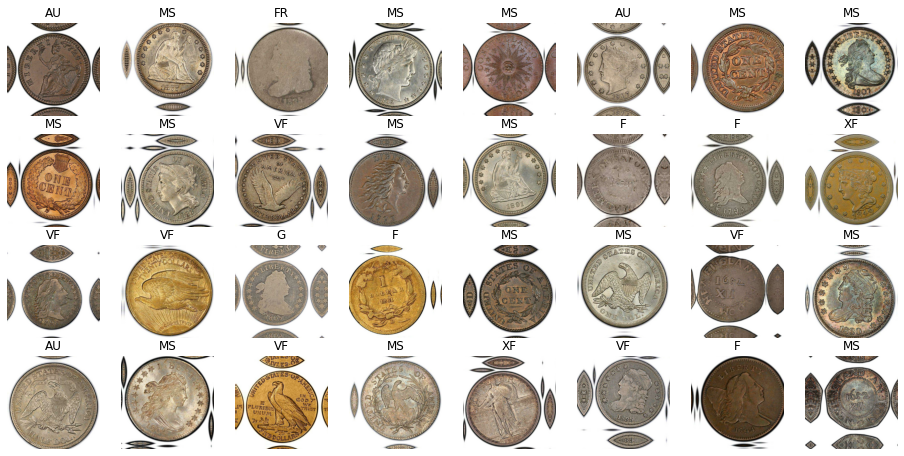

In [6]:
fig = plt.figure(figsize=(16, 16))
X_batch, y_batch = next(dataset.as_numpy_iterator())
X_batch = augment(X_batch)
for i in range(32):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[y_batch[i]])

# Create CNN:

In [1]:
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(30),
])
model.summary()

NameError: name 'models' is not defined

# Train Model:

In [6]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(dataset, epochs=20, validation_data=dataset_val)

Epoch 1/20
73/73 [==============================] - 257s 3s/step - loss: 1.5143 - accuracy: 0.4267 - val_loss: 1.4600 - val_accuracy: 0.4078
Epoch 2/20
73/73 [==============================] - 254s 3s/step - loss: 1.3352 - accuracy: 0.4820 - val_loss: 1.4504 - val_accuracy: 0.4408
Epoch 3/20
73/73 [==============================] - 251s 3s/step - loss: 1.2167 - accuracy: 0.5292 - val_loss: 1.4192 - val_accuracy: 0.4350
Epoch 4/20
73/73 [==============================] - 252s 3s/step - loss: 1.0901 - accuracy: 0.5798 - val_loss: 1.3660 - val_accuracy: 0.4544
Epoch 5/20
73/73 [==============================] - 250s 3s/step - loss: 0.9131 - accuracy: 0.6481 - val_loss: 1.4269 - val_accuracy: 0.4563
Epoch 6/20
73/73 [==============================] - 258s 4s/step - loss: 0.7761 - accuracy: 0.7110 - val_loss: 1.4992 - val_accuracy: 0.4718
Epoch 7/20
73/73 [==============================] - 270s 4s/step - loss: 0.5961 - accuracy: 0.7883 - val_loss: 1.8176 - val_accuracy: 0.4291
Epoch 8/20
73

KeyboardInterrupt: 

# Save/Load Model:

In [71]:
model.save('coin_grader_model')
# model = models.load_model('coin_grader_model')

2021-10-18 14:42:06.959672: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: coin_grader_model/assets


# Test Images:

In [61]:
correct = {}
total = {}
for i in range(len(labels)):
  correct[i] = 0
  total[i] = 0
for X, y in dataset:
  preds = [np.argmax(pred) for pred in model.predict(X)]
  for i, pred in enumerate(preds):
    true = y[i].numpy()
    if pred == true:
      correct[true] += 1
    total[true] += 1
for label, count in correct.items():
  acc = count / total[label]
  print('%s: %.2f' % (labels[label], acc))

AG: 0.95
AU: 0.94
F: 0.97
FR: 0.92
G: 1.00
MS: 1.00
PO: 1.00
VF: 0.98
VG: 0.99
XF: 0.99


1: MS
2: F
3: XF
4: AU
5: VF
Text:  



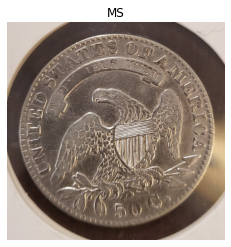

In [73]:
img = Image.open('test12.jpg')
img = img.resize(size=(500, 500))
img_data = np.divide(preprocessing.image.img_to_array(img), 255.0)

# X, y = next(dataset.as_numpy_iterator())
# img_data = X[0]
# print('True: %s' % labels[y[0]])

img_dataset = tf.data.Dataset.from_tensors([img_data])
prediction = model.predict(img_dataset)[0]
plt.title(labels[np.argmax(prediction)])
plt.axis('off')
plt.imshow(img_data)
ranked = np.argsort(prediction)
print('1: %s' % labels[ranked[-1]])
print('2: %s' % labels[ranked[-2]])
print('3: %s' % labels[ranked[-3]])
print('4: %s' % labels[ranked[-4]])
print('5: %s' % labels[ranked[-5]])

print('Text: %s' % pytesseract.image_to_string(img))